In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
data2 = pd.read_excel('/Users/yhj/Desktop/DATA_BOND.xlsx',header = 0, index_col = 0).dropna()

In [3]:
data2_std = np.std(data2/100, axis = 0 )

data2_std

1年国债到期收益率     0.007156
2年国债到期收益率     0.006772
3年国债到期收益率     0.006138
4年国债到期收益率     0.005763
5年国债到期收益率     0.005364
7年国债到期收益率     0.004866
10年国债到期收益率    0.004683
20年国债到期收益率    0.004223
30年国债到期收益率    0.004250
dtype: float64

In [4]:
data2_std.values

array([0.007156  , 0.00677198, 0.00613769, 0.0057633 , 0.00536434,
       0.00486635, 0.004683  , 0.00422286, 0.00425047])

In [5]:
terms = [1, 2, 3, 4, 5 , 7, 10, 20, 30]

In [6]:
def N_S(df, lda, terms):
    
    coef = np.zeros((len(terms),2))
    
    for x,y in zip(np.arange(len(terms)), terms):
        
        coef[x , 0]= (1-np.exp(-lda*y))/(lda*y)
        
        coef[x , 1]= (1-np.exp(-lda*y))/(lda*y) - np.exp(-lda*y)

    index = df.index
    
    beta_1 = []
    
    beta_2 = []
    
    beta_3 = []
    
    y_pred = []
    
    rmse = []
    
    for ind in index:
        
        y = df.loc[ind,:].values
        
        regressor = LinearRegression()
        
        regressor.fit(coef,y)
        
        beta_1.append(regressor.intercept_)
        
        beta_2.append(regressor.coef_[0])
        
        beta_3.append(regressor.coef_[1])
        
        y_pred.append(regressor.predict(coef))
        
        rmse.append(np.sqrt(mean_squared_error(y, regressor.predict(coef))))
        
    df_coef = pd.DataFrame({"b1":beta_1, "b2":beta_2, "b3": beta_3, "RMSE":rmse})
    
    df_coef.index = df.index
    
    df_pred = pd.DataFrame(y_pred, columns = df.columns)
    
    df_pred.index = df.index
    
    return df_coef, df_pred

In [7]:
def find_lambda(df, lda, terms): 
  
    best_rmse = np.inf
    
    best_lambda = 0
    
    for l in lda:
        
        rmse = N_S(df, l, terms)[0].loc[:,"RMSE"].cumsum()[-1]
        
        if best_rmse > rmse > 0:
            
            best_rmse = rmse
                
            best_lambda = l
    
    return best_rmse, best_lambda

In [30]:
multi_lambda = []

for i in np.arange(2009, 2022, 3):
    
    lmda = np.arange(0.1,0.4,0.01)
    
    best_lambda = find_lambda(data2[data2.index.year>= i].dropna()/100,lmda, terms)
    
    multi_lambda.append(best_lambda[1])

KeyboardInterrupt: 

In [8]:
reg_12y = N_S(data2[data2.index.year >= 2009].dropna()/100, 0.22999999999999995, terms)
reg_9y = N_S(data2[data2.index.year >= 2012].dropna()/100, 0.20999999999999996, terms)
reg_6y = N_S(data2[data2.index.year >= 2015].dropna()/100, 0.19999999999999996, terms)
reg_3y = N_S(data2[data2.index.year >= 2018].dropna()/100, 0.17999999999999997, terms)
reg_1y = N_S(data2[data2.index.year >= 2021].dropna()/100, 0.19999999999999996, terms)

In [9]:
df_betas_12y = reg_12y[0].loc[:, "b1":"b3"]
df_betas_9y = reg_9y[0].loc[:, "b1":"b3"]
df_betas_6y = reg_6y[0].loc[:, "b1":"b3"]
df_betas_3y = reg_3y[0].loc[:, "b1":"b3"]
df_betas_1y = reg_1y[0].loc[:, "b1":"b3"]

In [15]:
def AR_2(df, dt, ndays, p, d, q):
    
    date = pd.date_range(end = dt, periods = 2,freq = "12Y")
    
    start_date = date[0].strftime('%Y-%m-%d')
    
    betas = df.loc[start_date:dt,:]
    
    initial_value = []
    
    forecast = []
    
#     df_test = df.loc[dt:,:].index
    
#     test_index = df_test[0:ndays+1].strftime('%Y-%m-%d')
    
    now =  datetime.datetime.strptime(dt,'%Y-%m-%d')
    
    test_index = []
    
    for i in np.arange(ndays+1):
        
        delta = datetime.timedelta(days=int(i))
        
        n_days = now + delta
        
        test_index.append(n_days.strftime('%Y-%m-%d'))
    
    for col in betas.columns:
        
        coeff = betas[col].values
        
        model = ARIMA(coeff, order=(p,d,q))
        
        model_fit = model.fit()
        
        fc_initial = model_fit.forecast(1)[0]
        
        initial_value.append(fc_initial)
        
        fc = model_fit.forecast(ndays)[0]
        
        forecast.append(fc)
    
    fc_today = pd.DataFrame(initial_value).T
    
    fc_series = pd.DataFrame(forecast).T
    
    forecast = fc_today.append(fc_series, ignore_index=True)
    
    forecast.columns = ["b1","b2","b3"]
    
    forecast.index = test_index
    
    return forecast

In [16]:
def betas(b1,b2,b3,lmda,terms):
    
    y_hat = np.zeros(len(terms)) 
    
    for x,y in zip(range(len(terms)), terms):
        
         y_hat[x]= b1+b2*(1-np.exp(-lmda*y))/(lmda*y)+b3*((1-np.exp(-lmda*y))/(lmda*y) - np.exp(-lmda*y))          
    
    return y_hat

In [17]:
def forecast(date, optimal_lambda, terms, ar_1):
    
    b1_ar=ar_1.loc[date,"b1"]
    
    b2_ar=ar_1.loc[date,"b2"]
    
    b3_ar=ar_1.loc[date,"b3"]
    
    ar1=betas(b1_ar,b2_ar,b3_ar,optimal_lambda, terms)
    
    return ar1

In [18]:
d = "2021-08-04"

n_days = 5

ar_2 = AR_2(df_betas_12y, d, n_days,2, 0, 0)

/Users/yhj/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
ar_2

b1        b2        b3
2021-08-04  0.036238 -0.014794 -0.002366
2021-08-05  0.036238 -0.014794 -0.002366
2021-08-06  0.036259 -0.014766 -0.002381
2021-08-07  0.036281 -0.014765 -0.002390
2021-08-08  0.036303 -0.014772 -0.002396
2021-08-09  0.036326 -0.014781 -0.002403

In [20]:
list_total = []

for i in np.arange(1200):
    
    random_v = []
    
    for sd in data2_std.values:
        
        random_v.append(np.random.normal(0,sd**2))
    
    list_total.append(random_v)

t = np.array(list_total)

In [21]:
t

array([[-7.70335554e-05, -1.87454462e-05,  2.08936645e-05, ...,
         2.83930874e-05,  8.06158090e-06, -7.91961649e-06],
       [ 1.97189828e-05, -3.59425889e-05, -2.68430004e-06, ...,
         1.11629686e-05, -4.50742364e-06,  7.21591428e-06],
       [ 5.81566427e-06, -4.19964434e-06,  2.04489467e-05, ...,
        -2.88168668e-05,  2.36174556e-05, -1.67844409e-05],
       ...,
       [-5.64841188e-05,  3.61210091e-05,  5.54698394e-05, ...,
        -8.03727493e-06,  2.84931997e-05,  2.19401578e-06],
       [-2.13388556e-05,  6.06852491e-06, -2.76471021e-05, ...,
         2.31076321e-05,  1.88455878e-06, -1.02278033e-05],
       [ 2.43813148e-05, -3.06127436e-05,  1.24154310e-05, ...,
         4.18311911e-06,  9.18485223e-06, -1.74988292e-05]])

In [22]:
def day_5(ar):
    List = []
    for ind in ar.index:
        List.append(list(forecast(ind, 0.23, terms, ar)))
    ary = np.array(List)
    return ary[0], ary[1], ary[2], ary[3], ary[4], ary[5]

In [23]:
ary_1, ary_2, ary_3, ary_4, ary_5, ary_6 = day_5(ar_2)

In [24]:
ary_1 = ary_1 + t[0:200]

In [25]:
ary_2 = ary_2 + t[200:400]

In [26]:
ary_3 = ary_3 + t[400:600]

In [27]:
ary_4 = ary_4 + t[600:800]

In [28]:
ary_5 = ary_5 + t[800:1000]

In [29]:
ary_6 = ary_6 + t[1000:1200]

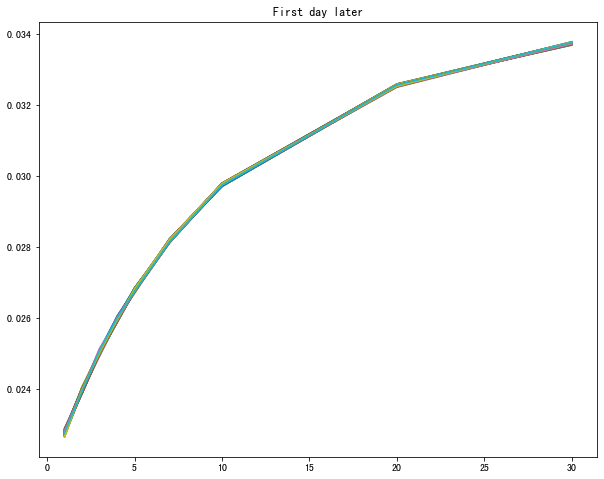

In [30]:
plt.figure(figsize = (10, 8))

for i in np.arange(len(ary_1)):
    plt.plot(terms, ary_1[i])
    plt.title("First day later")

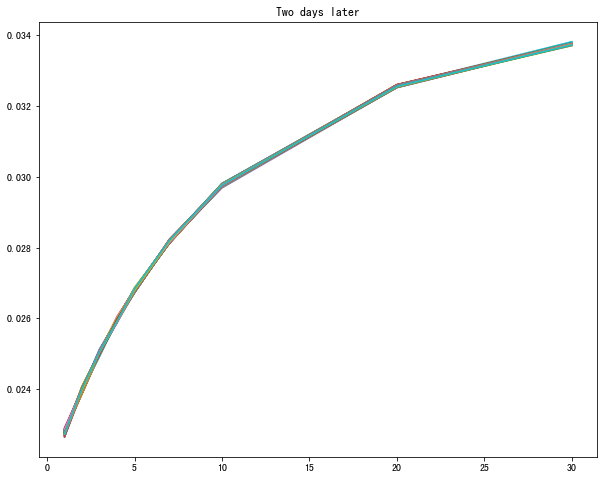

In [31]:
plt.figure(figsize = (10, 8))

for i in np.arange(len(ary_2)):
    plt.plot(terms, ary_2[i])
    plt.title("Two days later")

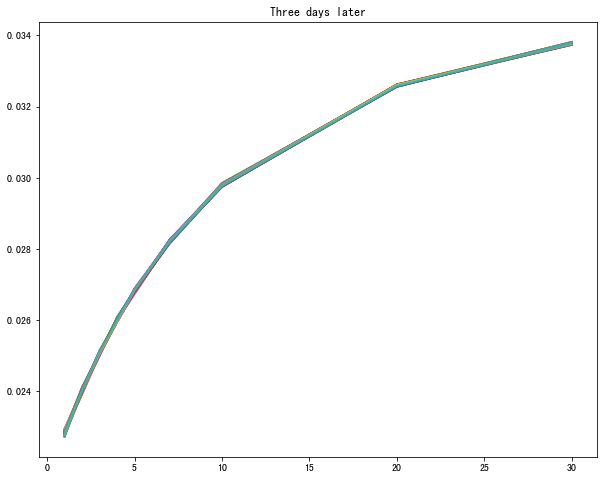

In [32]:
plt.figure(figsize = (10, 8))

for i in np.arange(len(ary_3)):
    plt.plot(terms, ary_3[i])
    plt.title("Three days later")

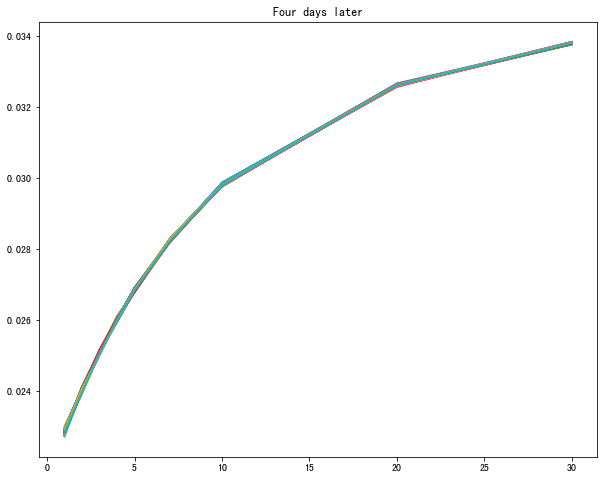

In [33]:
plt.figure(figsize = (10, 8))

for i in np.arange(len(ary_4)):
    plt.plot(terms, ary_4[i])
    plt.title("Four days later")

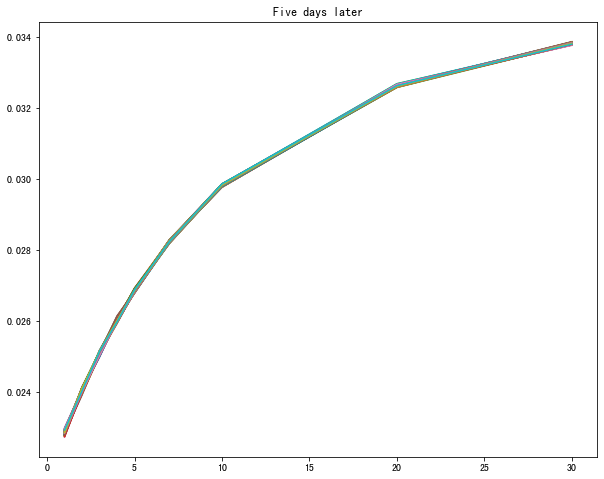

In [34]:
plt.figure(figsize = (10, 8))

for i in np.arange(len(ary_5)):
    plt.plot(terms, ary_5[i])
    plt.title("Five days later")

In [35]:
def final_result(numb, ar_2):
    df = pd.DataFrame(index = ar_2.index, columns = [i for i in np.arange(200)])
    df.loc[ar_2.index[0],:] = ary_1.T[numb]
    df.loc[ar_2.index[1],:] = ary_2.T[numb]
    df.loc[ar_2.index[2],:] = ary_3.T[numb]
    df.loc[ar_2.index[3],:] = ary_4.T[numb]
    df.loc[ar_2.index[4],:] = ary_5.T[numb]
    df.loc[ar_2.index[5],:] = ary_6.T[numb]
    return df

In [36]:
c = final_result(0,ar_2)

In [37]:
j = final_result(1,ar_2)

In [38]:
w = final_result(2,ar_2)

In [39]:
d = final_result(3,ar_2)

In [40]:
n = final_result(4,ar_2)

In [41]:
b = final_result(5,ar_2)

In [42]:
y = final_result(6,ar_2)

In [43]:
h = final_result(7,ar_2)

In [44]:
m = final_result(8,ar_2)

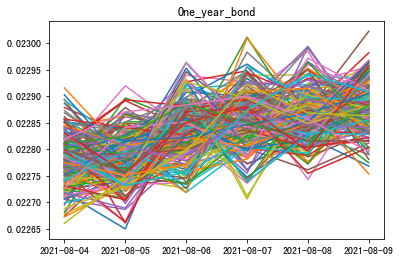

In [45]:
pp = PdfPages('one_year.pdf')
for i in np.arange(200):
    plt.plot(c.index, c.iloc[:,i])
    plt.title("One_year_bond")
pp.savefig()
pp.close()

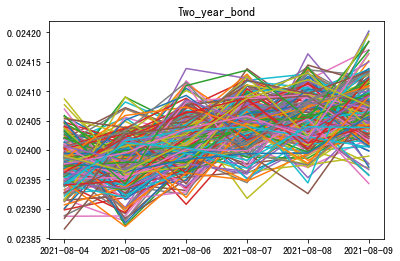

In [46]:
pp = PdfPages('two_year.pdf')
for i in np.arange(200):
    plt.plot(j.index, j.iloc[:,i])
    plt.title("Two_year_bond")
pp.savefig()
pp.close()

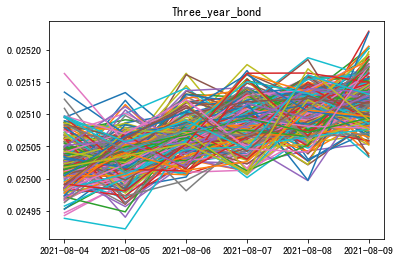

In [47]:
pp = PdfPages('Three_year.pdf')
for i in np.arange(200):
    plt.plot(w.index, w.iloc[:,i])
    plt.title("Three_year_bond")
pp.savefig()
pp.close()

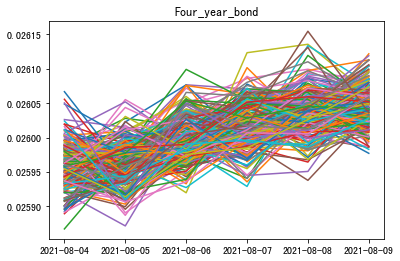

In [48]:
pp = PdfPages('Four_year.pdf')
for i in np.arange(200):
    plt.plot(d.index, d.iloc[:,i])
    plt.title("Four_year_bond")
pp.savefig()
pp.close()

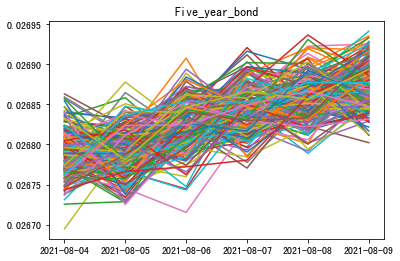

In [49]:
pp = PdfPages('Five_year.pdf')
for i in np.arange(200):
    plt.plot(n.index, n.iloc[:,i])
    plt.title("Five_year_bond")
pp.savefig()
pp.close()

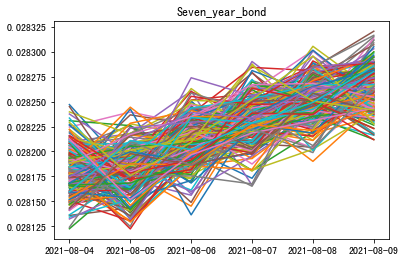

In [50]:
pp = PdfPages('Seven_year.pdf')
for i in np.arange(200):
    plt.plot(b.index, b.iloc[:,i])
    plt.title("Seven_year_bond")
pp.savefig()
pp.close()

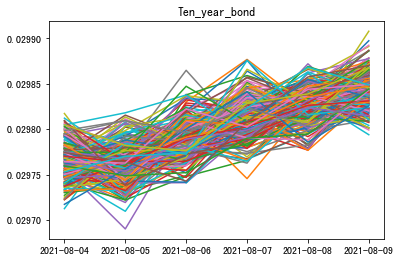

In [51]:
pp = PdfPages('Ten_year.pdf')
for i in np.arange(200):
    plt.plot(y.index, y.iloc[:,i])
    plt.title("Ten_year_bond")
pp.savefig()
pp.close()

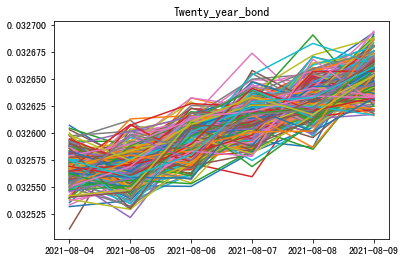

In [52]:
pp = PdfPages('Twenty_year.pdf')
for i in np.arange(200):
    plt.plot(h.index, h.iloc[:,i])
    plt.title("Twenty_year_bond")
pp.savefig()
pp.close()

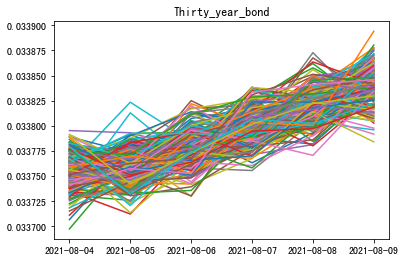

In [53]:
pp = PdfPages('Thirty_year.pdf')
for i in np.arange(200):
    plt.plot(m.index, m.iloc[:,i])
    plt.title("Thirty_year_bond")
pp.savefig()
pp.close()

In [54]:
from PyPDF2 import PdfFileMerger, PdfFileReader

merger = PdfFileMerger()

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/One_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Two_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Three_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Four_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Five_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Seven_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Ten_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Twenty_year.pdf", "rb"))

merger.append(PdfFileReader("/Users/yhj/Desktop/bit/cv/DNS/Thirty_year.pdf", "rb"))


merger.write("Result.pdf")